# Is It A Bird?

This is a modified version of the code following the YouTube video of the [Lesson 1: Practical Deep Learning for Coders 2022](https://www.youtube.com/watch?v=8SF_h3xF3cE). The main change is to avoid the limits imposed by DuckDuckGo when using the methods in the lecture so I am using this [solution](https://forums.fast.ai/t/ddg-images-doesnt-return-any-results/103782/6).

In [7]:
# ensure the latest versions of the librairies are installed (-U for upgrade and q for quiet)
# run run bash commands in a Python script by adding an ! in front of the command
!pip install -Uqq fastai
!pip install -Uqq fastbook

## Step 1: Download images of birds and non-birds

### Building the function

In [26]:
from fastbook import search_images_ddg

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return (search_images_ddg(term, max_images))

### Testing with a photo of a bird

First we retrive the image:

In [27]:
urls = search_images('bird', max_images=1)
urls[0]

Searching for 'bird'


'http://www.animal-photos.org/_photo/5079648.jpg'

And then we look at it:

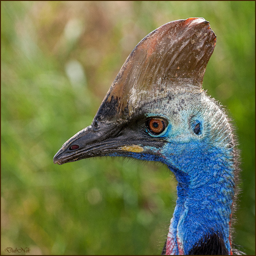

In [28]:
from fastdownload import download_url
dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

### Testing with a photo of a forest

In [29]:
urls = search_images('forest', max_images=1)
urls[0]

Searching for 'forest'


'http://wallup.net/wp-content/uploads/2015/12/246434-forest-landscape-mist.jpg'

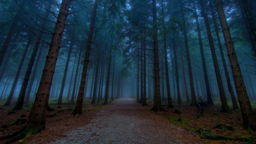

In [30]:
from fastdownload import download_url
dest = 'forest.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

The images look ok, so we can go ahead and download the images that will be used for training the model.

### Getting more photos of birds and forests

In [31]:
searches = 'forest','bird'
path = Path('bird_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'forest photo'
Searching for 'forest sun photo'
Searching for 'forest shade photo'
Searching for 'bird photo'
Searching for 'bird sun photo'
Searching for 'bird shade photo'


## Step 2: Train the model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [32]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

1

To train a model, we'll need DataLoaders (dls), which is an object that contains a training set (the images used to create a model) and a validation set (the images used to check the accuracy of a model -- not used during training).

In fastai we can create that easily using a DataBlock, and view sample images from it:

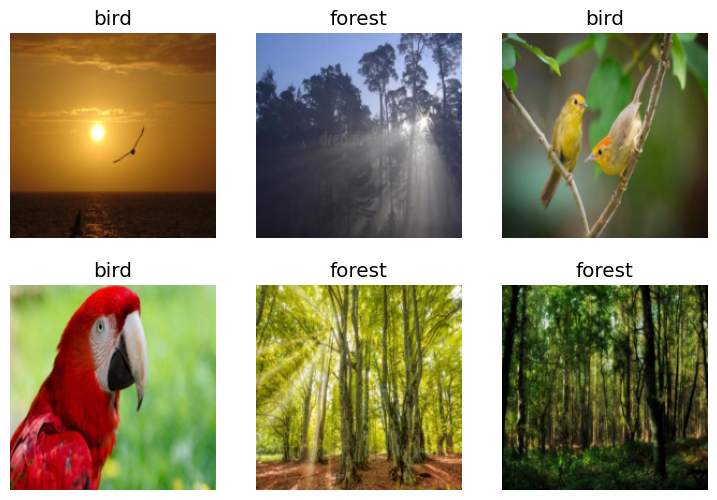

In [35]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

The DataBlock includes the things that change from project to project: 
- blocks: kind of input (here images) and kind of output (here categories) - this is enough for the model to know what kind of model to build
- get items: what are the things that I will be looking at to train this model? Here it is a function.
- splitter: data to test the accuracy of your model - set aside 20% of the data
- how do we know the correct label of the photo?
- make all the items the same size

DataLoaders are the things that PyTorch iterates through to grab a bunch of data at a time. It will feed the training algorithm with a batch of images at once. 

In [37]:
# in the learner below, you pass in the data (dls) and the model (resnet18)
# there are a lot of models, you can see on the fastai webside
# for this task, the resnet18 is expected to be good - the weights for the model
# are provided through the fastai library and it is then finetunning

learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

## Step 3: Use the model